In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# from jupyterthemes import jtplot
# jtplot.style()

In [2]:
import os
import gc
import cv2
import time
import itertools
import sklearn

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from keras import backend as K
from matplotlib import pyplot as plt

from glob import glob
from tqdm import tqdm
from itertools import cycle
from tabulate import tabulate
from pandas import DataFrame
from keras import regularizers, optimizers, initializers

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from keras.models import Sequential, Model
from keras.layers.core import Dense
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator

from keras.layers import (
    Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
)
from sklearn.metrics import (
    roc_curve, auc, multilabel_confusion_matrix, ConfusionMatrixDisplay, classification_report, confusion_matrix
)
from tensorflow.keras.applications import (
    VGG16, VGG19, InceptionV3, Xception, DenseNet121, ResNet50V2, MobileNet, MobileNetV2, EfficientNetB0, EfficientNetB1, 
    EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7, 
    NASNetMobile, NASNetLarge, MobileNetV3Large, MobileNetV3Small
)

In [3]:
def calculate_cm(y_true, y_pred):
    fp = np.sum((y_pred == 1) & (y_true == 0))
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    return tp, fp, fn, tn

def calculate_recall(tp, fp, fn, tn):
    return (tp)/(tp + fn)

def calculate_fallout(tp, fp, fn, tn):
    return (fp)/(fp + tn)

def calculate_fpr_tpr(y_true, y_pred):
    tp, fp, fn, tn = calculate_cm(y_true, y_pred)
    tpr = calculate_recall(tp, fp, fn, tn)
    fpr = calculate_fallout(tp, fp, fn, tn)
    return fpr, tpr

In [4]:
def plot_class_samples(samples_count):
    labels = list(samples_count.keys())
    count = list(samples_count.values())
    
    plt.rcParams['figure.dpi'] = 150
    fig, ax = plt.subplots(figsize =(18, 8))
    ax.barh(labels, count)
    
    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)
    
    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    
    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 2)
    ax.yaxis.set_tick_params(pad = 3)
    
    # Add x, y gridlines
    ax.grid(visible = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)
    
    # Show top values
    ax.invert_yaxis()
    
    # Add annotation to bars
    for i in ax.patches:
        plt.text(
            i.get_width() + 0.2, 
            i.get_y() + 0.5, 
            str(round((i.get_width()), 2)), 
            fontsize = 10, 
            fontweight = 'bold', 
            color ='grey'
        )
    
    ax.set_title('Samples Belonging to Each Class Label', loc ='center')
    plt.show()

In [5]:
# Data reading on Local Machine
image_paths = {os.path.basename(x): x for x in glob(os.path.join('.', 'images', '*.png'))}
df = pd.read_csv("./dataset_information/Data_Entry_2017.csv")

# Data reading on Kaggle
# image_paths = {os.path.basename(x): x for x in glob(os.path.join('..', 'input', 'data', 'images*', 'images', '*.png'))}
# df = pd.read_csv("/kaggle/input/data/Data_Entry_2017.csv")

df = df.drop(
    columns = [
        "Follow-up #", 
        "Patient ID", 
        "Patient Age", 
        "Patient Gender", 
        "OriginalImage[Width",
        "Height]",
        "OriginalImagePixelSpacing[x",
        "y]",
#         "Unnamed: 11",
        "View Position"
    ], 
    axis = 1
)

df["Image Paths"] = " "
for row_index in tqdm(range(len(df)), ncols = 100):
    img_name = df.iloc[row_index][0]
    path = image_paths[img_name]
    df["Image Paths"][row_index] = path

unique_labels = set(itertools.chain.from_iterable(df["Finding Labels"].apply(lambda x : x.split('|')).values)) 
one_hot_labels = pd.DataFrame(0.0, index = np.arange(len(df)), columns = unique_labels)

for index, row in tqdm(df.iterrows()):
    labels = row["Finding Labels"].split('|')
    for label in labels:
        one_hot_labels.iloc[index][label] = 1.0

df = pd.concat([df, one_hot_labels], axis = 1)
df = df.drop(columns = ["Finding Labels"], axis = 1)
# df.head(3)

100%|█████████████████████████████████████████████████████| 112120/112120 [01:09<00:00, 1620.51it/s]
112120it [00:22, 4927.64it/s]


In [6]:
new_dataset_dir = "D:/Datasets/GAN Images/"

df2 = pd.DataFrame(
    columns=[
        'Image Index', 'Image Paths', 
        'Pneumonia', 
        'Edema', 
        'Emphysema',
        'Hernia', 
        'Mass', 
        'Effusion', 
        'Nodule', 
        'Consolidation', 
        'No Finding',
        'Pneumothorax', 
        'Cardiomegaly', 
        'Pleural_Thickening', 
        'Fibrosis',
        'Atelectasis', 
        'Infiltration'
    ])

# Iterate through the folders in the new dataset directory
for class_name in os.listdir(new_dataset_dir):
    class_dir = os.path.join(new_dataset_dir, class_name)
    if not os.path.isdir(class_dir):
        continue

    # Iterate through the images in each class folder and extract the necessary information
    for image_name in tqdm(os.listdir(class_dir)):
        image_path = os.path.join(class_dir, image_name)
        image_index = image_name  # Assuming image name is unique and can be used as the index

        # Create a dictionary to hold the new row data
        new_row = {
            'Image Index': image_index,
            'Image Paths': image_path,
            'Pneumonia': 1 if class_name == 'Pneumonia' else 0,
            'Edema': 1 if class_name == 'Edema' else 0,
            'Emphysema': 1 if class_name == 'Emphysema' else 0,
            'Hernia': 1 if class_name == 'Hernia' else 0,
            'Mass': 1 if class_name == 'Mass' else 0,
            'Effusion': 1 if class_name == 'Effusion' else 0,
            'Nodule': 1 if class_name == 'Nodule' else 0,
            'Consolidation': 1 if class_name == 'Consolidation' else 0,
            'No Finding': 1 if class_name == 'No Finding' else 0,
            'Pneumothorax': 1 if class_name == 'Pneumothorax' else 0,
            'Cardiomegaly': 1 if class_name == 'Cardiomegaly' else 0,
            'Pleural_Thickening': 1 if class_name == 'Pleural_Thickening' else 0,
            'Fibrosis': 1 if class_name == 'Fibrosis' else 0,
            'Atelectasis': 1 if class_name == 'Atelectasis' else 0,
            'Infiltration': 1 if class_name == 'Infiltration' else 0
        }
        
        df2 = df2.append(new_row, ignore_index=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 228.48it/s]


In [7]:
df = pd.concat([df, df2], ignore_index=True)

In [8]:
df2

,Image Index,Image Paths,Pneumonia,Edema,Emphysema,Hernia,Mass,Effusion,Nodule,Consolidation,No Finding,Pneumothorax,Cardiomegaly,Pleural_Thickening,Fibrosis,Atelectasis,Infiltration
0,image_0.png,D:/Datasets/GAN Images/Cardiomegaly\image_0.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,image_1.png,D:/Datasets/GAN Images/Cardiomegaly\image_1.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,image_10.png,D:/Datasets/GAN Images/Cardiomegaly\image_10.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,image_100.png,D:/Datasets/GAN Images/Cardiomegaly\image_100.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,image_101.png,D:/Datasets/GAN Images/Cardiomegaly\image_101.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188,image_95.png,D:/Datasets/GAN Images/Pneumonia\image_95.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1189,image_96.png,D:/Datasets/GAN Images/Pneumonia\image_96.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1190,image_97.png,D:/Datasets/GAN Images/Pneumonia\image_97.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1191,image_98.png,D:/Datasets/GAN Images/Pneumonia\image_98.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
columns_to_convert = [
    'Pneumonia', 'Edema', 'Emphysema', 'Hernia', 'Mass', 'Effusion', 'Nodule', 'Consolidation', 'No Finding',
    'Pneumothorax', 'Cardiomegaly', 'Pleural_Thickening', 'Fibrosis', 'Atelectasis', 'Infiltration'
]
df[columns_to_convert] = df[columns_to_convert].astype(float)
df2[columns_to_convert] = df2[columns_to_convert].astype(float)

In [9]:
# df_train, df_test = train_test_split(dataset_info.sample(n = 60000), test_size = 0.20, random_state = 142)
df_train, df_test = train_test_split(df, test_size = 0.20, random_state = 500)
df_train, df_val = train_test_split(df_train, test_size = 0.10, random_state = 0)

print(f"Training Samples: {len(df_train)}\nValidation Samples: {len(df_val)}\nTesting Samples: {len(df_test)}")

Training Samples: 81585
Validation Samples: 9065
Testing Samples: 22663


In [9]:
# df_train = pd.concat([df_train, df2], ignore_index=True)

In [13]:
# df_train

,Image Index,Image Paths,Pneumothorax,Atelectasis,Infiltration,No Finding,Pneumonia,Cardiomegaly,Pleural_Thickening,Nodule,Fibrosis,Effusion,Emphysema,Hernia,Edema,Mass,Consolidation
0,00016366_001.png,.\images\00016366_001.png,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00019550_015.png,.\images\00019550_015.png,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00017698_003.png,.\images\00017698_003.png,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00018233_042.png,.\images\00018233_042.png,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00017136_017.png,.\images\00017136_017.png,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81914,image_95.png,D:/Datasets/GAN Images/Pneumonia\image_95.png,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81915,image_96.png,D:/Datasets/GAN Images/Pneumonia\image_96.png,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81916,image_97.png,D:/Datasets/GAN Images/Pneumonia\image_97.png,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81917,image_98.png,D:/Datasets/GAN Images/Pneumonia\image_98.png,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
CLASS_LABELS = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", 
    "Infiltration", "Mass", "No Finding", "Nodule", "Pleural_Thickening", "Pneumonia","Pneumothorax"
]

USE_TRANSFER_LEARNING = True
IMAGE_SIZE = (300, 300,)
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 0.0001 if USE_TRANSFER_LEARNING else 0.01

BETA_FOR_BIASED_RECALL = 1.3
BETA_FOR_BIASED_PRECISION = 0.7
BETA_WITH_NO_BIAS = 1

THRESHOLDS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

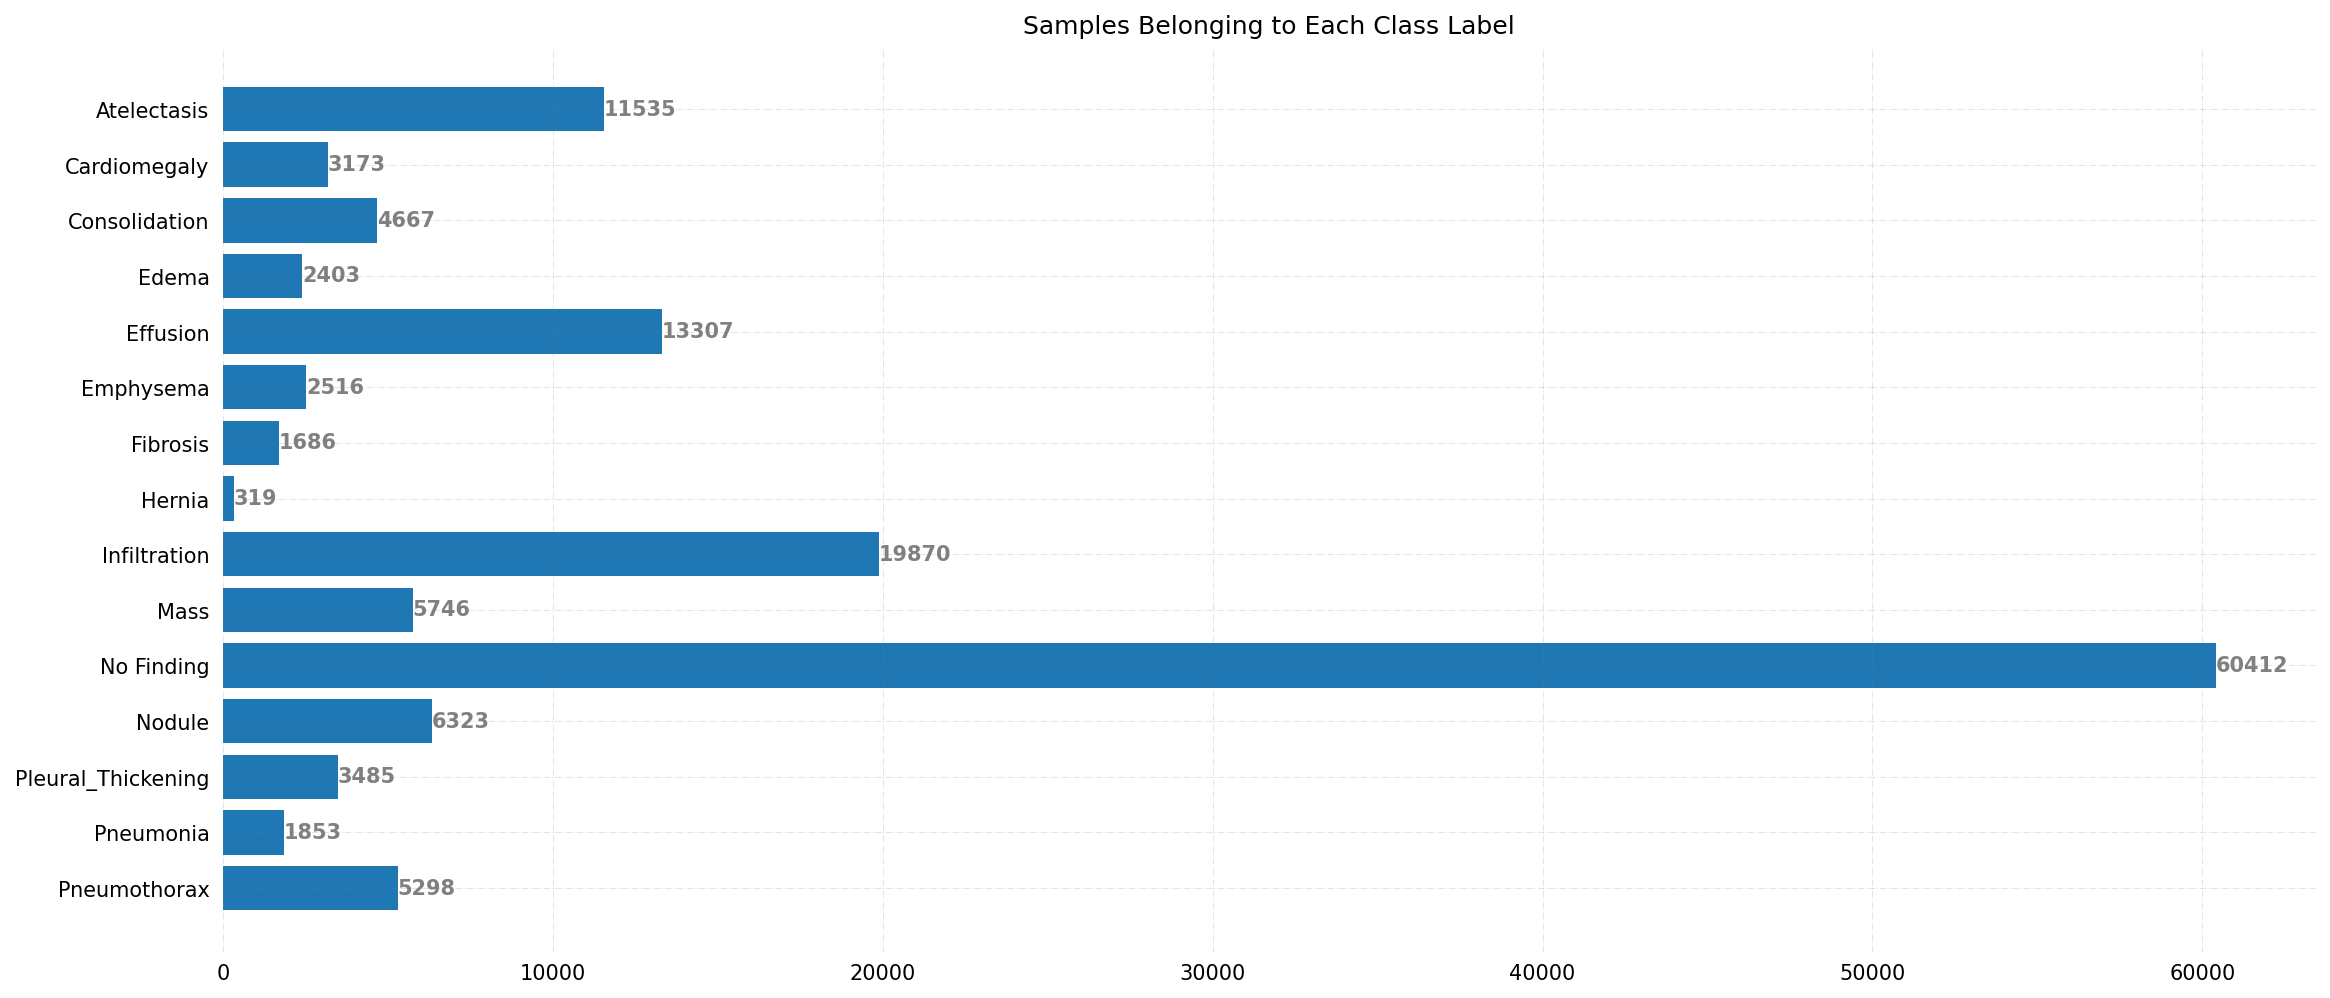

In [11]:
SAMPLES_PER_CLASS = dict()

for label in CLASS_LABELS:
    SAMPLES_PER_CLASS[label] = 0

for label in CLASS_LABELS:
    SAMPLES_PER_CLASS[label] = int(df[label].sum())
    
plot_class_samples(SAMPLES_PER_CLASS)

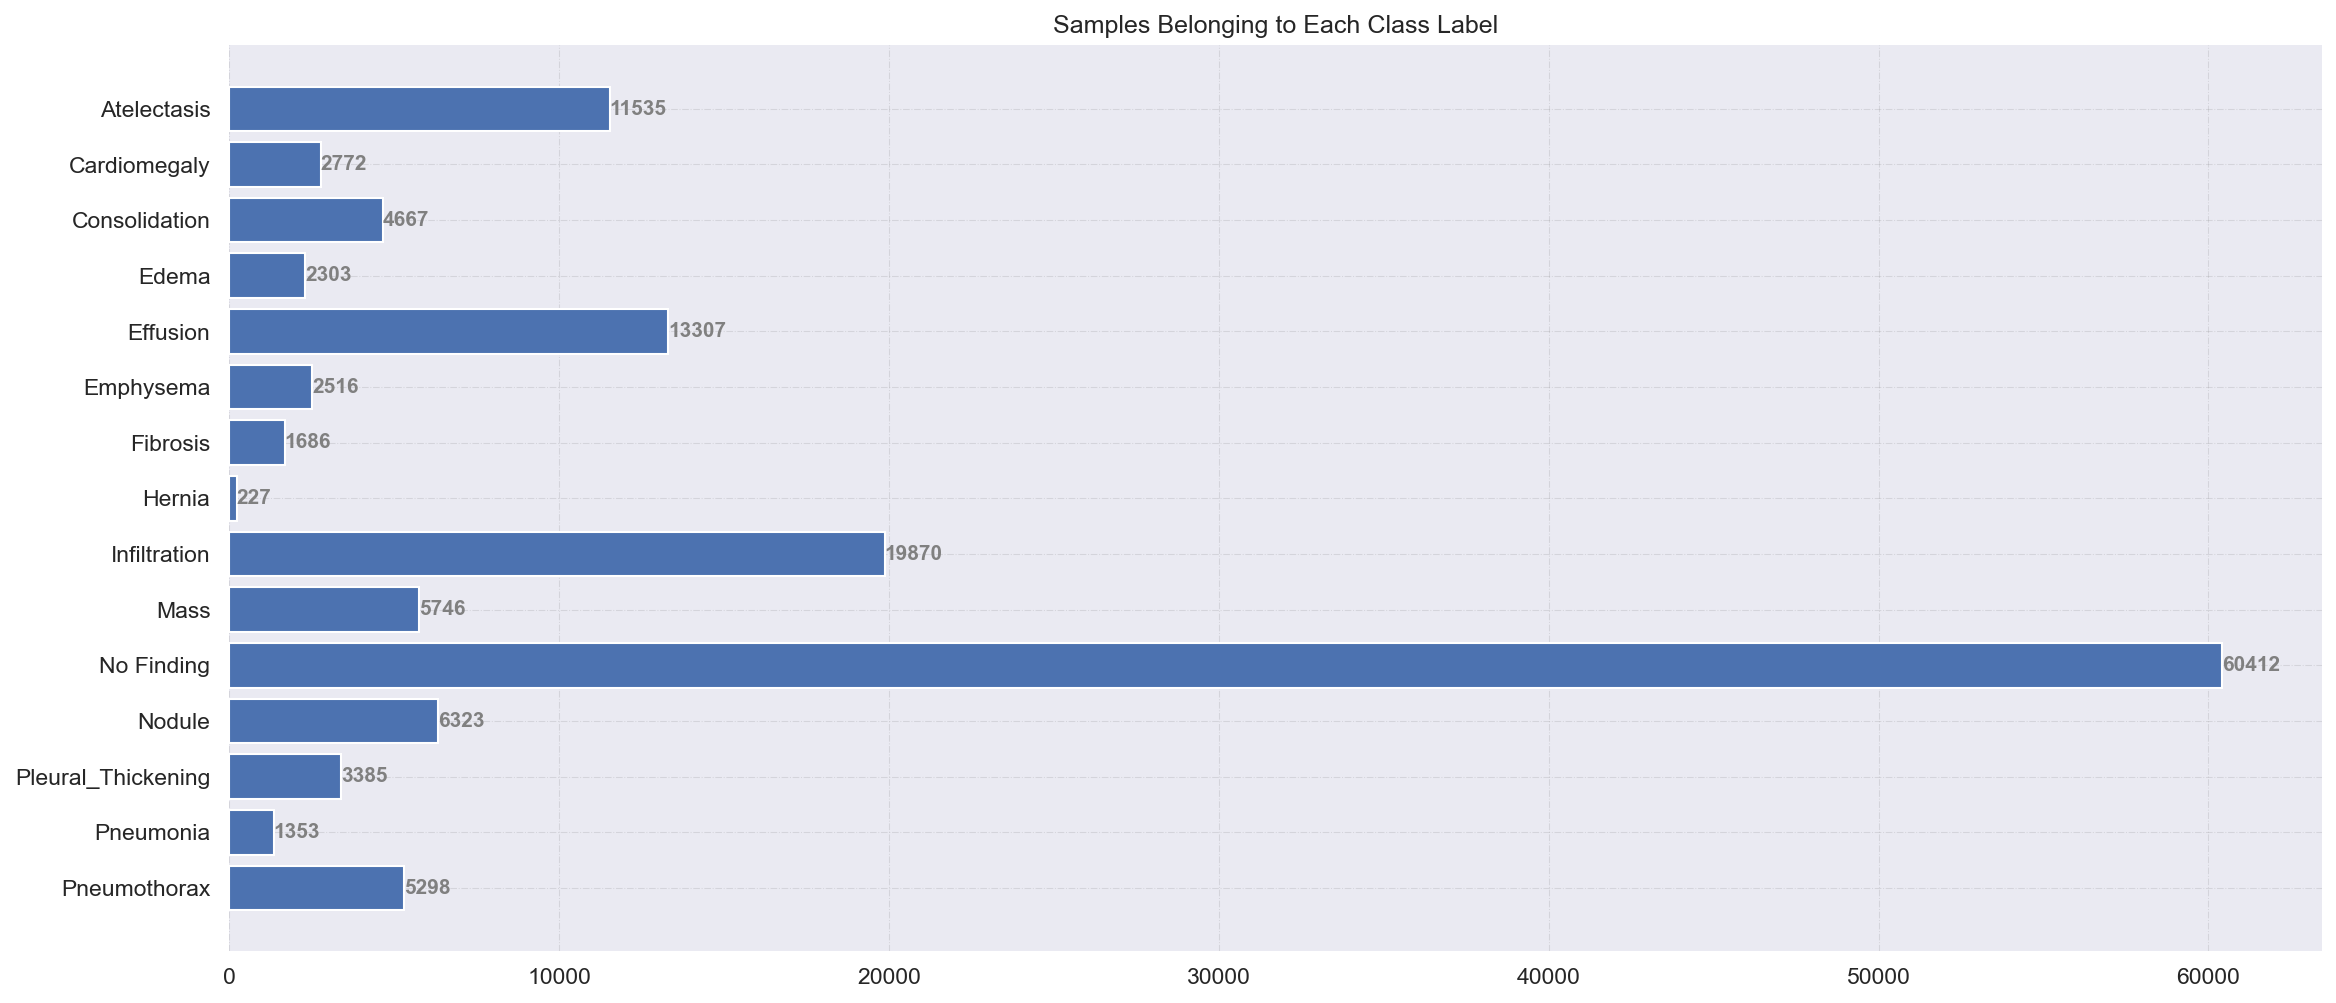

In [138]:
# SAMPLES_PER_CLASS = dict()

# for label in CLASS_LABELS:
#     SAMPLES_PER_CLASS[label] = 0

# for label in CLASS_LABELS:
#     SAMPLES_PER_CLASS[label] = int(df[label].sum())
    
# plot_class_samples(SAMPLES_PER_CLASS)

<AxesSubplot:>

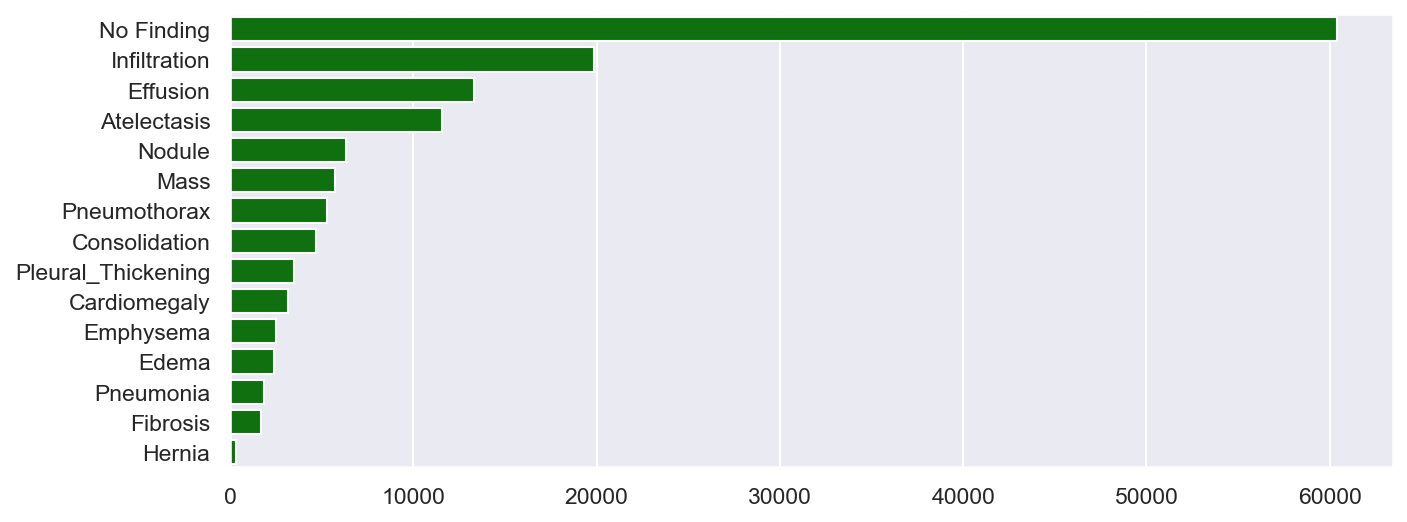

In [12]:
SORTED_SAMPLES_PER_CLASS = dict(sorted(SAMPLES_PER_CLASS.items(), key=lambda x:x[1], reverse = True))
keys = list(SORTED_SAMPLES_PER_CLASS.keys())
values = list(SORTED_SAMPLES_PER_CLASS.values())

sns.set(rc = {'figure.figsize' : (10, 4)})
sns.barplot(x = values, y = keys, color = "green")

<AxesSubplot:>

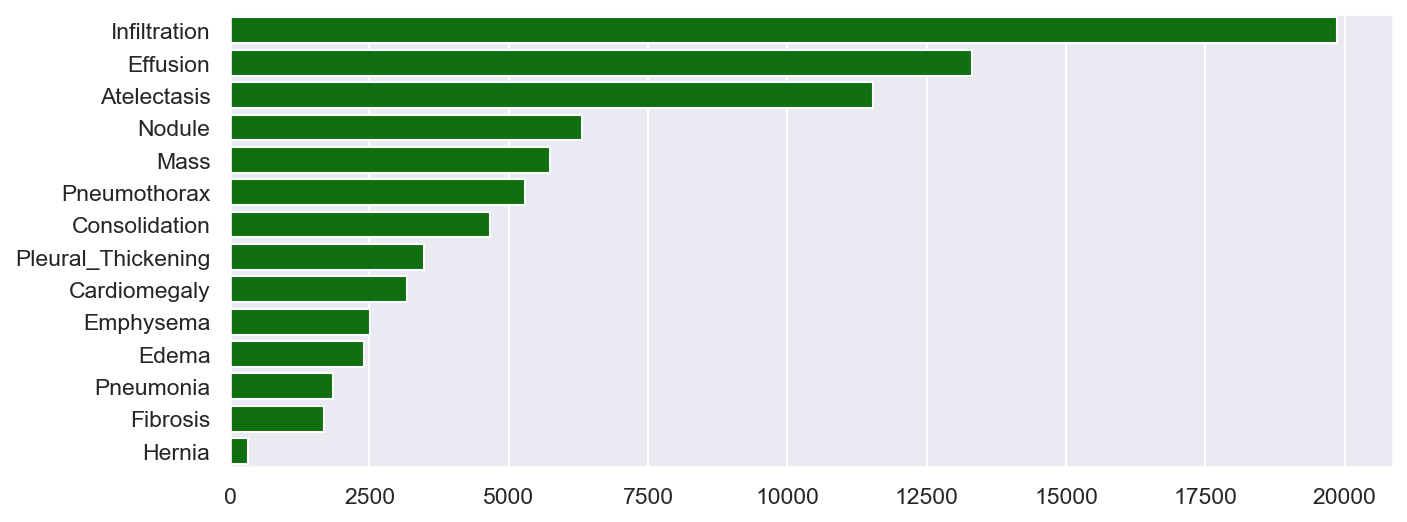

In [13]:
del(SORTED_SAMPLES_PER_CLASS["No Finding"])
keys = list(SORTED_SAMPLES_PER_CLASS.keys())
values = list(SORTED_SAMPLES_PER_CLASS.values())

sns.barplot(x = values, y = keys, color = "green")

In [14]:
CLASS_WEIGHTS = dict()
label_with_most_samples = max(SAMPLES_PER_CLASS, key = SAMPLES_PER_CLASS.get)

for index, label in enumerate(CLASS_LABELS):
    CLASS_WEIGHTS[index] = SAMPLES_PER_CLASS[label_with_most_samples] / (len(CLASS_LABELS) * SAMPLES_PER_CLASS[label])

tabulated_weights_data = []    
for i in range(15):
    row = [CLASS_LABELS[i], SAMPLES_PER_CLASS[CLASS_LABELS[i]], CLASS_WEIGHTS[i]]
    tabulated_weights_data.append(row)
    
print(tabulate(tabulated_weights_data, headers = ["Class Name", "Samples", "Weightage"], tablefmt = "github", numalign = "left"))

| Class Name         | Samples   | Weightage   |
|--------------------|-----------|-------------|
| Atelectasis        | 11535     | 0.349152    |
| Cardiomegaly       | 3173      | 1.26929     |
| Consolidation      | 4667      | 0.862967    |
| Edema              | 2403      | 1.67602     |
| Effusion           | 13307     | 0.302658    |
| Emphysema          | 2516      | 1.60074     |
| Fibrosis           | 1686      | 2.38877     |
| Hernia             | 319       | 12.6253     |
| Infiltration       | 19870     | 0.202691    |
| Mass               | 5746      | 0.700917    |
| No Finding         | 60412     | 0.0666667   |
| Nodule             | 6323      | 0.636955    |
| Pleural_Thickening | 3485      | 1.15566     |
| Pneumonia          | 1853      | 2.17348     |
| Pneumothorax       | 5298      | 0.760186    |


In [15]:
def apply_sharpening(image):
    sharp_kernel = np.array(
        [
            [0, -1, 0], 
            [-1, 5, -1], 
            [0, -1, 0]
        ])
    output = cv2.filter2D(src = image, ddepth = -1, kernel = sharp_kernel)
    return output


def apply_min_max_scaling(image):
    image = (image - image.min()) / (image.max() - image.min())
    return image


def one_minus_one_normalization(image):
    normalized_image = (image.astype(np.float32) / 127.5) - 1 # Convert pixel values to range [-1, 1]
    return normalized_image


def otsu_preprocess(img):
    # Convert the input image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Convert the grayscale image to an 8-bit image
    gray_8bit = np.uint8(gray)
    
    # Apply Otsu's method to obtain a binary mask
    thresh, binary = cv2.threshold(gray_8bit, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Apply the binary mask to the input image
    preprocessed_img = cv2.bitwise_and(img, img, mask=binary)
    
    output = one_minus_one_normalization(preprocessed_img)
#     print(output)
    
    return output

In [16]:
train_data_generator = ImageDataGenerator(
    rescale = 1. / 255,
    shear_range = 0.2,
    zoom_range = 0.05,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    fill_mode = "constant",
    preprocessing_function = apply_sharpening,
#     featurewise_center = True,
#     featurewise_std_normalization = True,
#     samplewise_center = True,
#     samplewise_std_normalization = True,
)

val_data_generator = ImageDataGenerator(
    rescale = 1. / 255, 
    preprocessing_function = apply_sharpening
)

test_data_generator = ImageDataGenerator(
    rescale = 1. / 255, 
    preprocessing_function = apply_sharpening
)


def flow_from_dataframe(image_generator, dataframe):
    df_gen = image_generator.flow_from_dataframe(
        dataframe,
        x_col = "Image Paths", 
        y_col = dataframe.columns[2:],
        target_size = IMAGE_SIZE,
        color_mode = 'rgb',
        class_mode = 'raw',
        shuffle = False,
        batch_size = BATCH_SIZE
    )
    return df_gen


train_gen = flow_from_dataframe(image_generator = train_data_generator, dataframe = df_train)
valid_gen = flow_from_dataframe(image_generator = val_data_generator, dataframe = df_val)
test_gen = flow_from_dataframe(image_generator = test_data_generator, dataframe = df_test)

Found 81585 validated image filenames.
Found 9065 validated image filenames.
Found 22663 validated image filenames.


In [17]:
# plt.rcParams["figure.figsize"] = (3,3)

# x = train_gen.next()
# # print(len(x[0][0]))

# for i in range(1):
#     for j in range(10):
#         image = x[i][j]
# #         plt.imshow(image)
#         plt.imshow((image * 255).astype(np.uint8))
#         plt.show()

In [18]:
# t_x, t_y = next(train_gen)
# fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
# for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0])
#     c_ax.set_title(', '.join([n_class for n_class, n_score in zip(CLASS_LABELS, c_y) if n_score > 0.5]))
#     c_ax.axis('off')

# train_gen.reset()

In [19]:
# class MultiLabelCrossEntropy:
#     def __init__(self, labels: DataFrame, epsilon = 1e-7):
#         self.epsilon = epsilon
#         self.N = labels.shape[0]
        
#         self.freq_pos = np.sum(labels == 1, axis=0)
#         self.freq_neg = np.sum(labels == 0, axis=0)
#         self.pos_weights = self.freq_neg  / self.N
#         self.neg_weights = self.freq_pos  / self.N
        
#         self.print_class_weights()
        
#     def calculate_loss(self, true_y, pred_y):
#         loss = 0.0
#         for i in range(len(self.pos_weights)):
#             loss += (-1 * K.mean(self.pos_weights[i] * true_y[:,i] * K.log(pred_y[:,i] + self.epsilon))) + (-1 * K.mean(self.neg_weights[i] * (1 - true_y[:,i]) * K.log(1 - pred_y[:,i] + self.epsilon)))
        
#         return loss
        
#     def contribution(self):
#         return self.freq_pos * self.pos_weights, self.freq_neg * self.neg_weights
    
#     def print_class_weights(self):
#         tabulated_weights_data = []
#         for i, l in zip(range(15), CLASS_LABELS):
#             label_samples_percentage = (self.freq_pos[i] / SAMPLES_PER_CLASS[l]) * 100 
#             row = [CLASS_LABELS[i], SAMPLES_PER_CLASS[l], self.freq_pos[i], label_samples_percentage, self.freq_neg[i], self.pos_weights[i], self.neg_weights[i]]
#             tabulated_weights_data.append(row)
            
#         print(tabulate(
#             tabulated_weights_data, 
#             headers = ["Class", "Total Samples", "Positive Samples [Train]",  "Sample Percentage [Train]","Negative Frequency [Train]", "Positive Weight", "Negative Weight"], 
#             tablefmt = "github", 
#             numalign = "left"
#         ))

        
# MLCE_Loss_With_Class_Weights = MultiLabelCrossEntropy(df_train[CLASS_LABELS])

In [17]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 4, verbose = 1, mode = 'auto', baseline = None, restore_best_weights = True)

METRICS = [
  tf.keras.metrics.TruePositives(name = 'tp'),
  tf.keras.metrics.FalsePositives(name = 'fp'),
  tf.keras.metrics.TrueNegatives(name = 'tn'),
  tf.keras.metrics.FalseNegatives(name = 'fn'), 
  tf.keras.metrics.BinaryAccuracy(name = 'binary_accuracy', threshold = 0.5),
  tf.keras.metrics.Precision(name = 'precision', thresholds = 0.3),
  tf.keras.metrics.Recall(name = 'recall', thresholds = 0.3),
  tf.keras.metrics.AUC(name = 'auc', multi_label = True, num_labels = 15, thresholds = THRESHOLDS),
  tf.keras.metrics.AUC(name = 'prc', curve = 'PR')
]

DEFINED_OPTIMIZERS = {
    "SGD" : tf.keras.optimizers.SGD(learning_rate = LEARNING_RATE, decay = 1e-6, momentum = 0.9, nesterov = True),
    "ADAM" : tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, beta_1 = 0.9, beta_2 = 0.999,),
    "RMSPROP" : tf.keras.optimizers.RMSprop(learning_rate = LEARNING_RATE),
    "NADAM" : tf.keras.optimizers.Nadam(learning_rate = LEARNING_RATE,),
    "ADAMAX" : tf.keras.optimizers.Adamax(learning_rate = LEARNING_RATE,),
    "ADAGRAD" : tf.keras.optimizers.Adagrad(learning_rate = LEARNING_RATE,)
}

DEFINED_LOSSES = {
    "BCE" : "binary_crossentropy", 
#     "MLBCE_CW" : MLCE_Loss_With_Class_Weights.calculate_loss
}

In [19]:
channels = (3,)
input_shape = IMAGE_SIZE + channels
img_input = Input(shape = input_shape)

# MobileNetV3Large, MobileNetV3Small
MODEL_NAME = "MobileNetV2"
base_model = MobileNetV2(
    input_shape = input_shape,
    include_top = False,
    weights = "imagenet" if USE_TRANSFER_LEARNING else None
)

classifier = Sequential()
# classifier.add(Flatten())
classifier.add(GlobalAveragePooling2D(input_shape = base_model.output_shape[1:]))
classifier.add(Dropout(0.2))

classifier.add(Dense(256))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
classifier.add(Dropout(0.2))

classifier.add(Dense(50))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
classifier.add(Dropout(0.2))

classifier.add(Dense(15, activation = "sigmoid"))

model = Model(inputs = base_model.input, outputs = classifier(base_model.output))
# model.load_weights(f"./saved_weights_BCE/MobileNet_5_weights_GAN_DATA_2.h5")

model.compile(
    optimizer = DEFINED_OPTIMIZERS["ADAM"],
#     loss = DEFINED_LOSSES["MLBCE_CW"],
    loss = DEFINED_LOSSES["BCE"],
    metrics = METRICS,
)

USE_CLASS_WEIGHTS_IN_MODEL_FIT = False

In [24]:
# model.summary()

In [20]:
start_time = time.time()

history = model.fit(
    epochs = EPOCHS,
    x = train_gen,
    validation_data = valid_gen,  
    steps_per_epoch = train_gen.n / train_gen.batch_size,
    validation_steps = valid_gen.n / valid_gen.batch_size,
    shuffle = False,
    callbacks = None,
    verbose = 1,
    class_weight = CLASS_WEIGHTS if USE_CLASS_WEIGHTS_IN_MODEL_FIT else None,
)

print(f"\nTime Taken: {(time.time() - start_time) / 3600 : .4f} Hours")

Epoch 1/10
5099/5099 [==============================] - 3811s 746ms/step - loss: 0.2785 - tp: 34708.0000 - fp: 59102.0000 - tn: 1061964.0000 - fn: 68001.0000 - binary_accuracy: 0.8961 - precision: 0.2540 - recall: 0.5190 - auc: 0.5773 - prc: 0.3122 - val_loss: 0.1905 - val_tp: 3578.0000 - val_fp: 1361.0000 - val_tn: 123342.0000 - val_fn: 7694.0000 - val_binary_accuracy: 0.9334 - val_precision: 0.5607 - val_recall: 0.4890 - val_auc: 0.6094 - val_prc: 0.5294
Epoch 2/10
5099/5099 [==============================] - 4115s 807ms/step - loss: 0.1943 - tp: 34277.0000 - fp: 15394.0000 - tn: 1105672.0000 - fn: 68432.0000 - binary_accuracy: 0.9315 - precision: 0.5316 - recall: 0.5009 - auc: 0.6408 - prc: 0.5160 - val_loss: 0.1824 - val_tp: 3865.0000 - val_fp: 1535.0000 - val_tn: 123168.0000 - val_fn: 7407.0000 - val_binary_accuracy: 0.9342 - val_precision: 0.5559 - val_recall: 0.5194 - val_auc: 0.6764 - val_prc: 0.5516
Epoch 3/10
5099/5099 [==============================] - 3648s 715ms/step - los

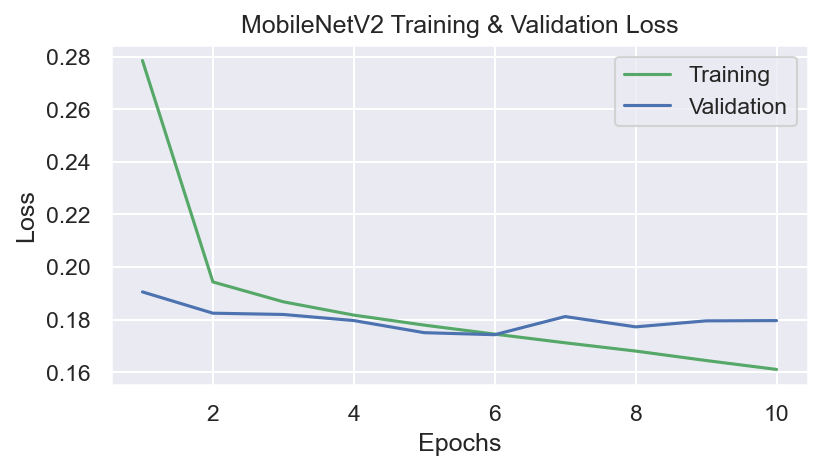

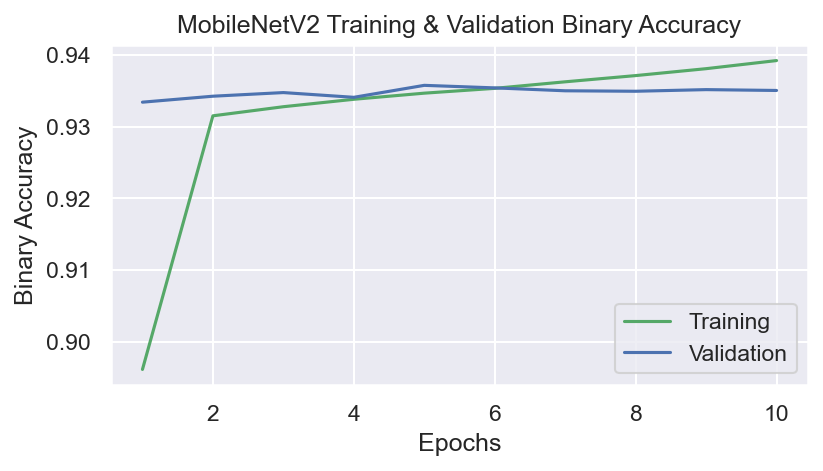

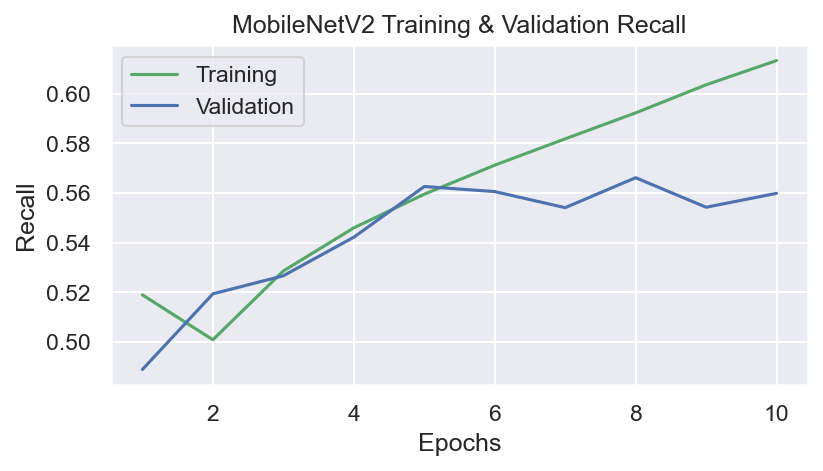

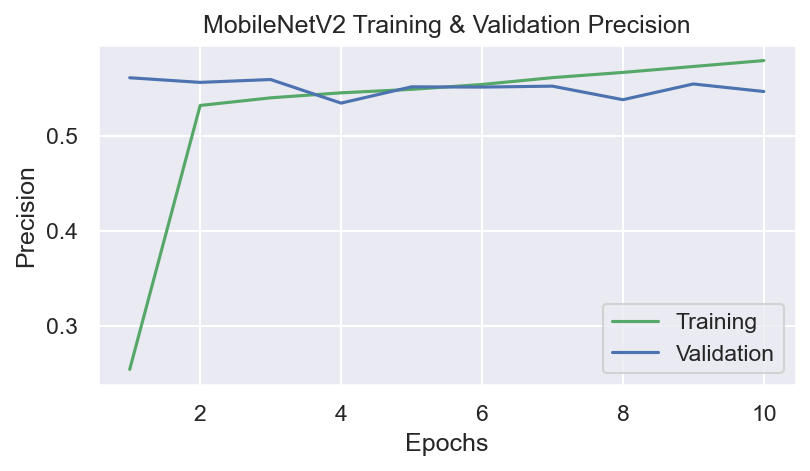

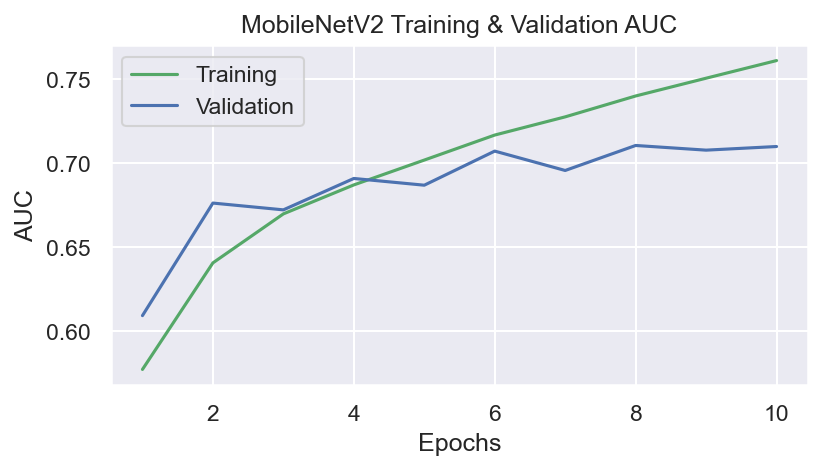

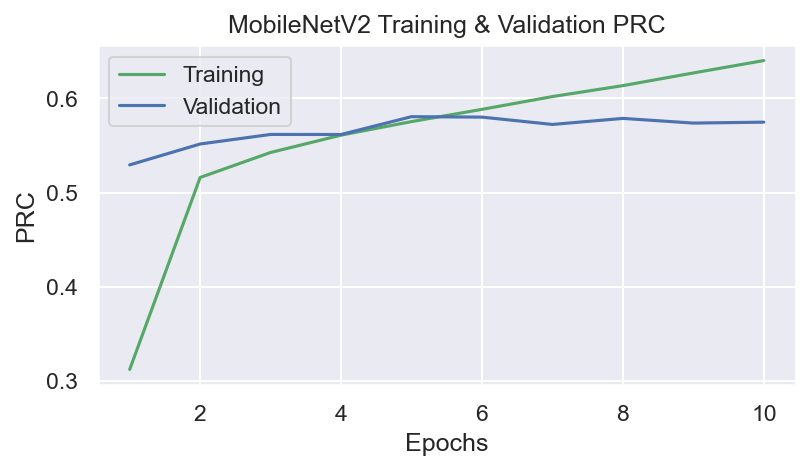

In [21]:
plt.figure(1, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['loss'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_loss'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(2, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['binary_accuracy'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_binary_accuracy'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Binary Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Binary Accuracy')
plt.legend()
plt.show()

plt.figure(3, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['recall'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_recall'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

plt.figure(4, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['precision'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_precision'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

plt.figure(6, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['auc'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_auc'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

plt.figure(7, figsize = (6,3))
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['prc'], 'g', label = 'Training')
plt.plot([int(x) for x in range(1, EPOCHS + 1)], history.history['val_prc'], 'b', label = 'Validation')
plt.title(f'{MODEL_NAME} Training & Validation PRC')
plt.xlabel('Epochs')
plt.ylabel('PRC')
plt.legend()
plt.show()

In [22]:
model.save_weights(f"./saved_weights_BCE/{MODEL_NAME}_{EPOCHS}_weights_GAN_DATA.h5")
evaluation = model.evaluate(test_gen)

1417/1417 [==============================] - 577s 407ms/step - loss: 0.1831 - tp: 11491.0000 - fp: 5351.0000 - tn: 305982.0000 - fn: 17121.0000 - binary_accuracy: 0.9339 - precision: 0.5497 - recall: 0.5556 - auc: 0.6993 - prc: 0.5733


In [23]:
test_loss = evaluation[0]
TP = evaluation[1]
FP = evaluation[2]
TN = evaluation[3]
FN = evaluation[4]
binary_accuracy = evaluation[5] * 100
auc = evaluation[8] * 100
auc_pr = evaluation[9] * 100

specificity = (TN / (TN + FP)) * 100
recall = (TP / (TP + FN)) * 100
precision = (TP / (TP + FP)) * 100
f1_score = (2 * recall * precision) / (recall + precision)

print(f"Testing Loss: \t\t{test_loss}\n")
print(f"True Positives: \t{TP}\nFalse Positives: \t{FP}\nTrue Negatives: \t{TN}\nFalse Negatives: \t{FN}\n")
print(f"Binary Accuracy: \t{binary_accuracy}")
print(f"Average Recall: \t{recall}\nAverage Precision: \t{precision}\nF1-Score: \t\t{f1_score}\nAverage Specificity: \t{specificity}\n")
print(f"AUC: \t\t\t{auc}\nAUC-PR: \t\t{auc_pr}")

Testing Loss: 		0.1830526441335678

True Positives: 	11491.0
False Positives: 	5351.0
True Negatives: 	305982.0
False Negatives: 	17121.0

Binary Accuracy: 	93.38939785957336
Average Recall: 	40.161470711589544
Average Precision: 	68.22823892649329
F1-Score: 		50.56100673208079
Average Specificity: 	98.28126154310658

AUC: 			69.93342638015747
AUC-PR: 		57.32594132423401


In [24]:
test_gen.reset()
predictions = model.predict(test_gen)

In [25]:
def binary_accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

def precision_threshold(threshold = 0.5):
    def precision(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(y_pred)
        precision_ratio = true_positives / (predicted_positives + K.epsilon())
        return precision_ratio
    return precision

def recall_threshold(threshold = 0.5):
    def recall(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.clip(y_true, 0, 1))
        recall_ratio = true_positives / (possible_positives + K.epsilon())
        return recall_ratio
    return recall

def fbeta_score_threshold(beta = 1, threshold = 0.5):
    def fbeta_score(y_true, y_pred):
        threshold_value = threshold
        beta_value = beta
        p = precision_threshold(threshold_value)(y_true, y_pred)
        r = recall_threshold(threshold_value)(y_true, y_pred)
        bb = beta_value ** 2
        fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
        return fbeta_score
    return fbeta_score
    
def print_results(beta, threshold, test_labels, prediction):
    accuracy = K.eval(binary_accuracy(K.variable(value = test_labels), K.variable(value = prediction)))
    precision = K.eval(precision_threshold(threshold = threshold)(K.variable(value = test_labels), K.variable(value = prediction)))
    recall = K.eval(recall_threshold(threshold = threshold)(K.variable(value = test_labels), K.variable(value = prediction)))
    f1_score = K.eval(fbeta_score_threshold(beta = beta, threshold = threshold)(K.variable(value = test_labels), K.variable(value = prediction)))
    print(f"BETA: {beta}, THRESHOLD: {threshold}")
    print (f"Binary Accuracy: \t{accuracy * 100} % \nRecall: \t\t{recall * 100} % \nPrecision: \t\t{precision * 100} % \nF1-Score: \t\t{f1_score * 100} %\n")

In [26]:
test_labels = []
for label in test_gen.labels:
    test_labels.append(label)

# # Results with F Score giving more weightage to Recall
# for threshold in THRESHOLDS:
#     print_results(beta = BETA_FOR_BIASED_RECALL, threshold = threshold, test_labels = test_labels, prediction = predictions)

# # Results with F Score giving more weightage to Precision
# for threshold in THRESHOLDS:
#     print_results(beta = BETA_FOR_BIASED_PRECISION, threshold = threshold, test_labels = test_labels, prediction = predictions)

# Results with F Score giving equal weightage to Recall and Precision
for threshold in THRESHOLDS:
    print_results(beta = BETA_WITH_NO_BIAS, threshold = threshold, test_labels = test_labels, prediction = predictions)

BETA: 1, THRESHOLD: 0.1
Binary Accuracy: 	93.38951706886292 % 
Recall: 		76.59373879432678 % 
Precision: 		36.16754412651062 % 
F1-Score: 		49.134013056755066 %

BETA: 1, THRESHOLD: 0.2
Binary Accuracy: 	93.38951706886292 % 
Recall: 		64.7909939289093 % 
Precision: 		46.75056040287018 % 
F1-Score: 		54.31186556816101 %

BETA: 1, THRESHOLD: 0.3
Binary Accuracy: 	93.38951706886292 % 
Recall: 		55.560606718063354 % 
Precision: 		54.968881607055664 % 
F1-Score: 		55.26314973831177 %

BETA: 1, THRESHOLD: 0.4
Binary Accuracy: 	93.38951706886292 % 
Recall: 		47.759681940078735 % 
Precision: 		61.754339933395386 % 
F1-Score: 		53.86282801628113 %

BETA: 1, THRESHOLD: 0.5
Binary Accuracy: 	93.38951706886292 % 
Recall: 		40.16146957874298 % 
Precision: 		68.22823882102966 % 
F1-Score: 		50.56099891662598 %

BETA: 1, THRESHOLD: 0.6
Binary Accuracy: 	93.38951706886292 % 
Recall: 		33.894869685173035 % 
Precision: 		73.11519980430603 % 
F1-Score: 		46.3176965713501 %

BETA: 1, THRESHOLD: 0.7
Binary

In [27]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize = 14):
    df_cm = pd.DataFrame(confusion_matrix, index = class_names, columns = class_names,)

    try:
        heatmap = sns.heatmap(df_cm, annot = True, fmt = "d", cbar = False, ax = axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 45, ha = 'right', fontsize = fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix - " + class_label)

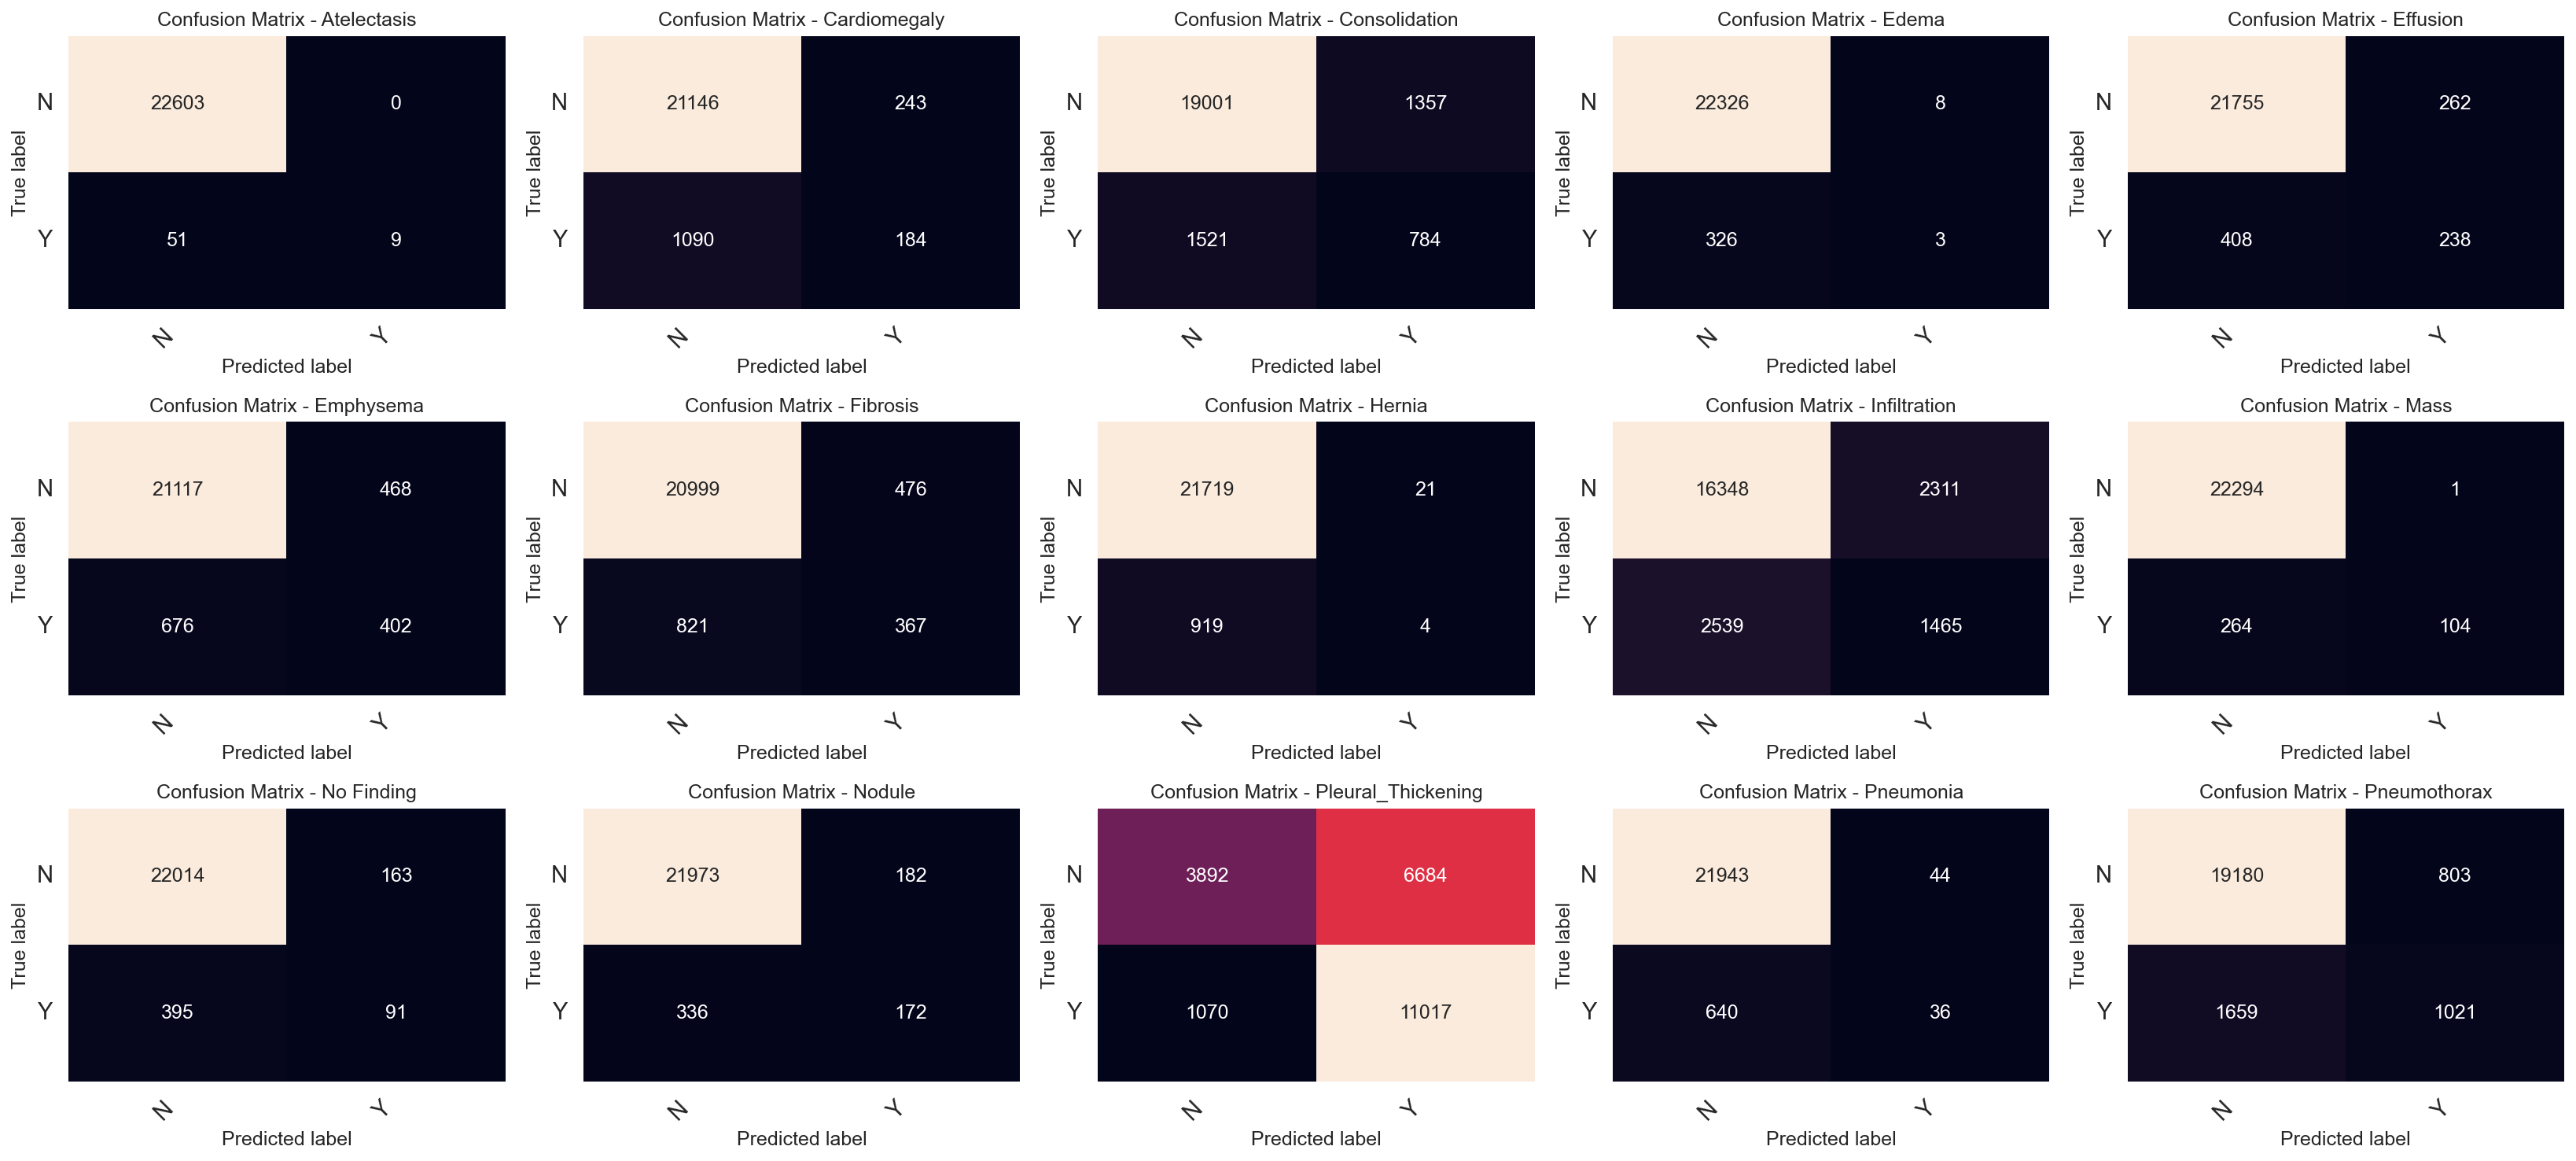

In [28]:
threshold = 0.3
y_test = test_gen.labels
y_predicted = (predictions >= threshold).astype(int)
confusion_matrix = multilabel_confusion_matrix(y_test, y_predicted)

fig, ax = plt.subplots(3, 5, figsize=(22, 10))
for axes, cfs_matrix, label in zip(ax.flatten(), confusion_matrix, CLASS_LABELS):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

[MobileNetV2 with 10 Epochs] - Average AUC: 0.8195008266342783


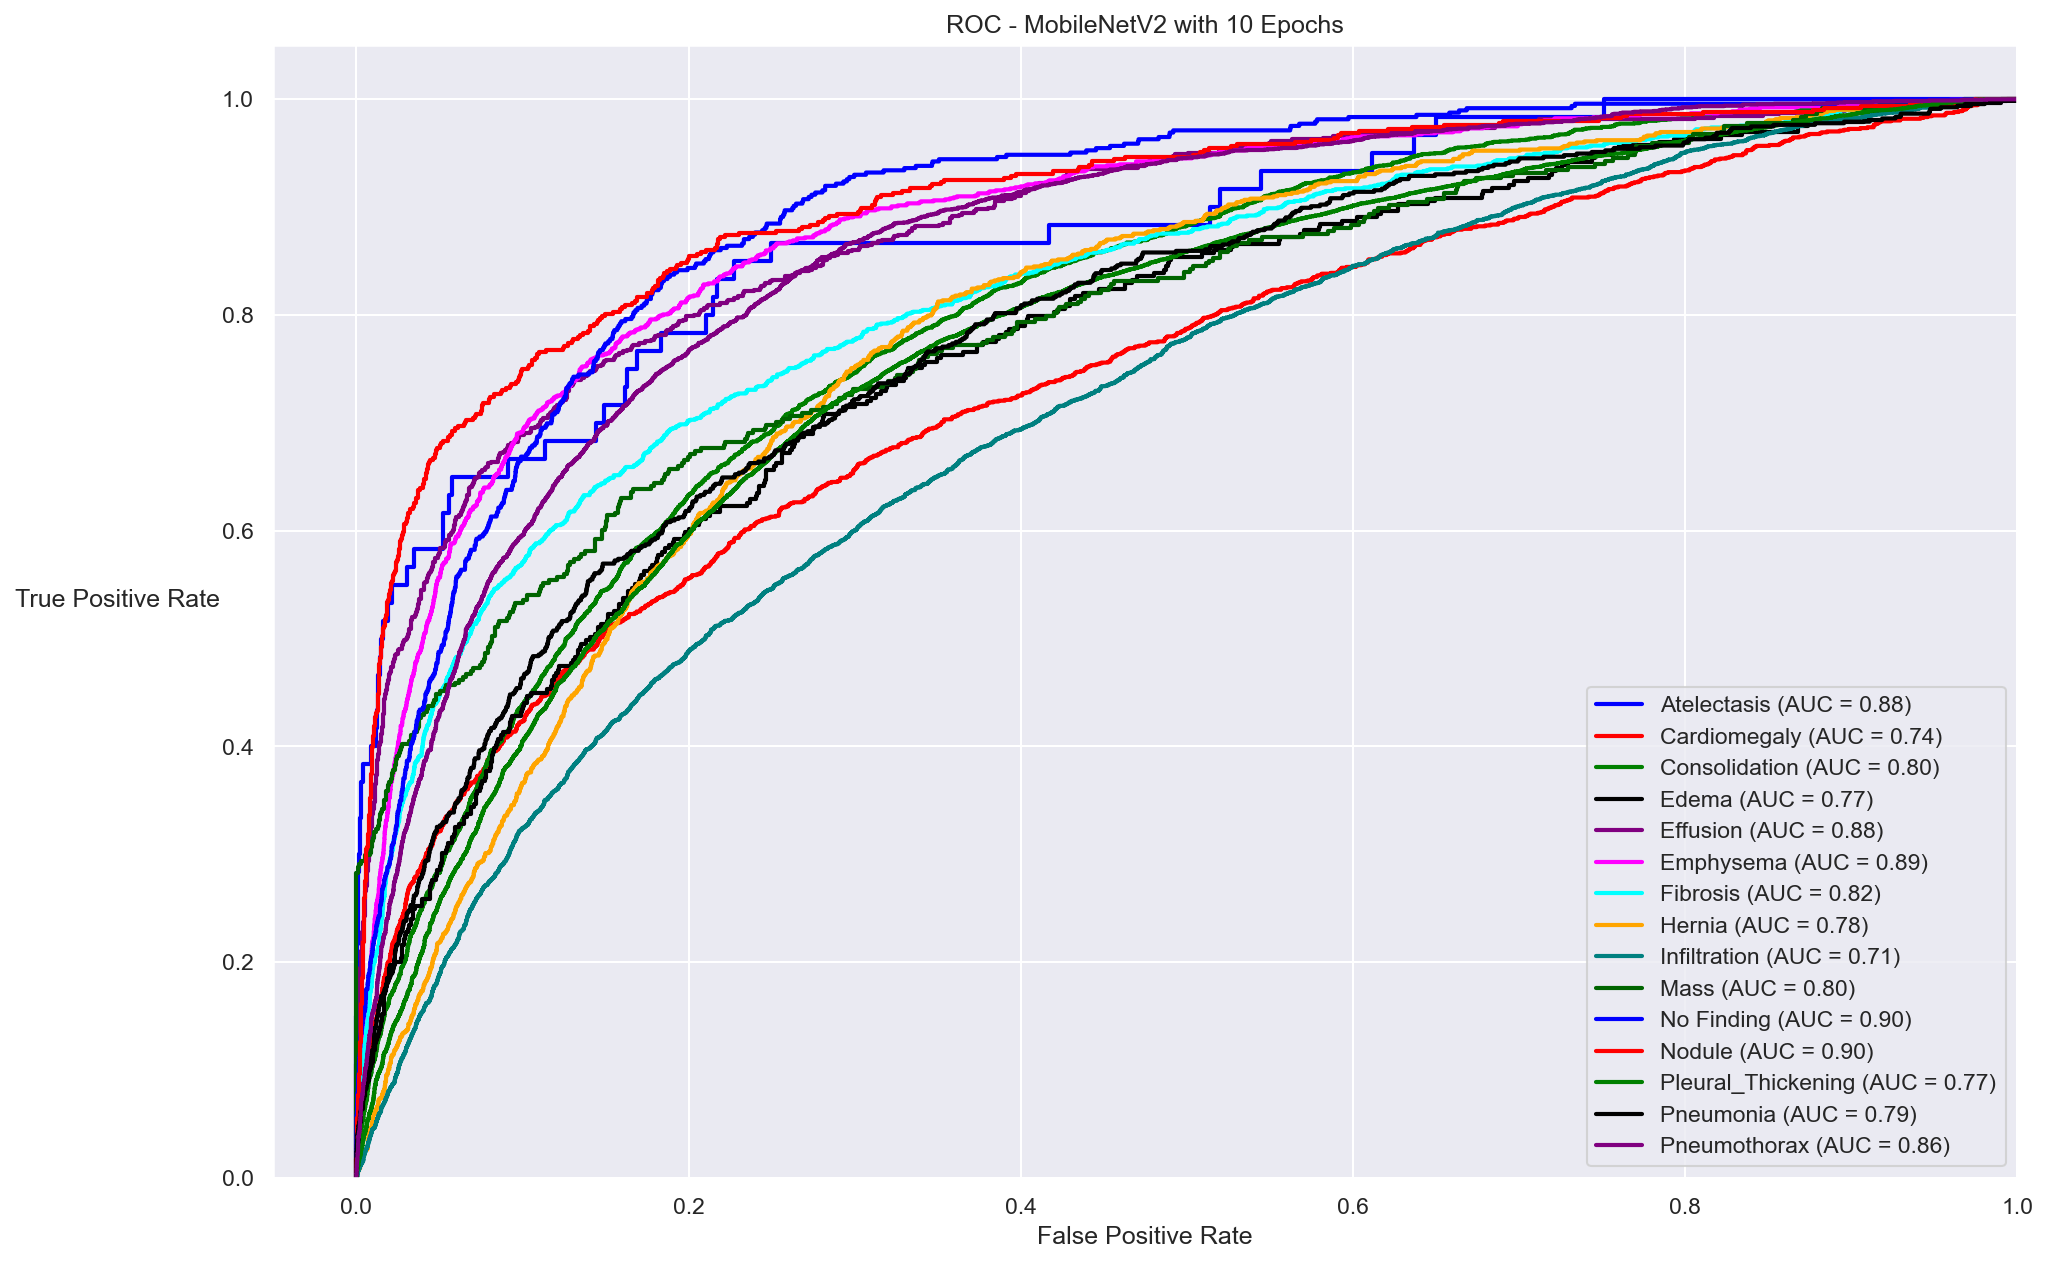

In [29]:
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['figure.dpi'] = 150

colors = cycle(['blue', 'red', 'green', 'black', 'purple', 'magenta', 'cyan', 'orange', 'teal', 'darkgreen'])
fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 2

for i in range(len(CLASS_LABELS)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions[:, i])
    roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])

avg_auc = 0
for auc_value in roc_auc.values():
    avg_auc += auc_value

print(f"[{MODEL_NAME} with {10} Epochs] - Average AUC: {avg_auc / 15}")
    
for i, color in zip(range(len(CLASS_LABELS)), colors):
    plt.plot(fpr[i], tpr[i], color = color, lw = 2, label = '{0} (AUC = {1:0.2f})'''.format(CLASS_LABELS[i], roc_auc[i]))

plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate', rotation = 0, labelpad = 50)
plt.title(f'ROC - {MODEL_NAME} with {10} Epochs')
plt.legend(loc = "lower right")
plt.show()